In [1]:
pip install datasets transformers --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 5.0 MB/s eta 0:00:00a 0:00:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.12.0 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.8.4.1 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cudnn-cu12==9.1.0.70; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cudnn-cu12 9.3.0.75 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cufft-cu12==11.2.1.3; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cufft-cu12 11.3.3.83 which is incompatible.
torch 2.5.1+cu124 requires nvidia-curand-cu12==10.3.5.147; platform_system == "Linux" and platfo

In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

2025-04-10 12:14:32.614731: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744287272.802895      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744287272.858510      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
IMG_SIZE = (224, 224)
NUM_CLASSES = 3

In [4]:
dir1 = "/kaggle/input/Video/Video"
dir2 = "/kaggle/input/UNBER_IG/UNBER_IG/Video_IG"

In [5]:
def load_video_frames(video_folder):
    frames = []
    frame_files = sorted(os.listdir(video_folder))
    for file in frame_files:
        img_path = os.path.join(video_folder, file)
        img = load_img(img_path, target_size=IMG_SIZE)
        img = img_to_array(img)
        frames.append(img)

    return np.array(frames)

In [6]:
TEXT_CSV = "/kaggle/input/BNREEL_text.csv"

In [7]:
import pandas as pd
tdf = pd.read_csv(TEXT_CSV)

In [8]:
tdf

,file_id,class,text,source,category
0,1000188341415358,Safe,Me on my way to watch Oppenheimer After Berbie,Facebook,Safe
1,1006146964533997,Safe,[NULL],Facebook,Safe
2,1007123741459823,Adult,বান্ধবী আমার লাগানির পিনিকে আছে Love in love,Facebook,Unsafe
3,1007420607202244,Safe,প্রত্যেকটা অফিসে এমন একজন কলিগ থাকবেই Laptop,Facebook,Safe
4,1008519870870927,Safe,হ্যালো শার্ক ট্যাঙ্ক বাংলাদেশ আই এম কামিং,Facebook,Safe
...,...,...,...,...,...
1916,3356285208118215619_62841927222,Safe,The amount of comfort this scene gives >>,Instagram,Safe
1917,3363424170779680862_62841927222_2,Safe,Anupam Roy's voice is line medicine for all br...,Instagram,Safe
1918,3363424170779680862_62841927222_3,Safe,Anupam Roy's voice is line medicine for all br...,Instagram,Safe
1919,3363424170779680862_62841927222_,Safe,Anupam Roy's voice is line medicine for all br...,Instagram,Safe


In [9]:
tdf = tdf[tdf['category']=='Unsafe']

In [10]:
tdf['class'].value_counts()

class
Adult       467
Harmful     321
Suicidal    276
Name: count, dtype: int64

In [11]:
tdf['class'], uniques = pd.factorize(tdf['class'])
uniques

/tmp/ipykernel_31/413459185.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdf['class'], uniques = pd.factorize(tdf['class'])


Index(['Adult', 'Harmful', 'Suicidal'], dtype='object')

In [12]:
X_video, y = [], []

In [13]:
for _, row in tdf.iterrows():
    reel_id = row["file_id"] 
    label = row["class"]  

    for dir in [dir1, dir2]:
        video_folder = os.path.join(dir, reel_id)
        if os.path.isdir(video_folder):
            frames = load_video_frames(video_folder)

            # Fix the frame count to exactly 15
            if frames.shape[0] < 10:
                # Pad with last frame
                pad_count = 10 - frames.shape[0]
                last_frame = frames[-1:]
                pad_frames = np.repeat(last_frame, pad_count, axis=0)
                frames = np.concatenate([frames, pad_frames], axis=0)
            elif frames.shape[0] > 10:
                # Truncate extra frames
                frames = frames[:10]

            if frames.shape == (10, 224, 224, 3):
                X_video.append(frames)
                y.append(label)
            else:
                print(reel_id, "Shape mismatch:", frames.shape)

In [14]:
X_video = np.array(X_video)  
y = np.array(y)

In [15]:
print(X_video.shape)
print(y.shape)

(1064, 10, 224, 224, 3)
(1064,)


In [16]:
X_train_vid, X_temp, y_train, y_temp = train_test_split(X_video, y, test_size=0.2, random_state=42, stratify=y)
X_val_vid, X_test_vid, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [17]:
print(X_train_vid.shape)
print(X_val_vid.shape)
print(X_test_vid.shape)

(851, 10, 224, 224, 3)
(106, 10, 224, 224, 3)
(107, 10, 224, 224, 3)


In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import ViTModel, ViTFeatureExtractor

In [19]:
model_name_or_path = "google/vit-base-patch16-224"
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name_or_path)

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [20]:
vit_model = ViTModel.from_pretrained(model_name_or_path)
vit_model.eval()

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTModel(
  (embeddings): ViTEmbeddings(
    (patch_embeddings): ViTPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): ViTEncoder(
    (layer): ModuleList(
      (0-11): 12 x ViTLayer(
        (attention): ViTAttention(
          (attention): ViTSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
          )
          (output): ViTSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (intermediate): ViTIntermediate(
          (dense): Linear(in_features=768, out_features=3072, bias=True)
          (intermediate_act_fn): GELUActivation()
        )
        (output): ViTOutput(
          (d

In [21]:
import torch.nn as nn
import torch

class ViT_LSTM_Model(nn.Module):
    def __init__(self, vit_model, lstm_hidden_size=512, dropout=0.3, num_classes=3):
        super(ViT_LSTM_Model, self).__init__()
        self.vit = vit_model
        self.lstm_hidden_size = lstm_hidden_size

        # Fine-tune only the last 2 transformer blocks
        for name, param in self.vit.named_parameters():
            if "encoder.layer.10" in name or "encoder.layer.11" in name:
                param.requires_grad = True
            else:
                param.requires_grad = False

        # LSTM to capture temporal dependencies
        self.lstm = nn.LSTM(input_size=768, hidden_size=lstm_hidden_size, num_layers=1, batch_first=True)

        self.dropout = nn.Dropout(dropout)
        self.bn = nn.BatchNorm1d(lstm_hidden_size)

        # Fully connected for multiclass
        self.fc = nn.Linear(lstm_hidden_size, num_classes)

    def forward(self, x):
        batch_size, num_frames, c, h, w = x.shape
        x = x.view(batch_size * num_frames, c, h, w)

        # Only detach if you’re freezing ViT completely
        vit_out = self.vit(x).last_hidden_state[:, 0, :]  # CLS token

        features = vit_out.view(batch_size, num_frames, -1)

        lstm_out, _ = self.lstm(features)
        final_feature = lstm_out[:, -1, :]  # (batch, hidden)

        final_feature = self.dropout(final_feature)
        final_feature = self.bn(final_feature)

        return self.fc(final_feature)  # (batch, num_classes)

In [22]:
from torch.utils.data import Dataset, DataLoader
import numpy as np

In [23]:
class VideoDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        video = self.X[idx]  # Shape: (num_frames, 224, 224, 3)
        label = self.y[idx]

        # Convert to tensor and normalize
        video = torch.tensor(video, dtype=torch.float32).permute(0, 3, 1, 2) / 255.0  # (num_frames, 3, 224, 224)
        return video, torch.tensor(label, dtype=torch.long)

In [24]:
train_dataset = VideoDataset(X_train_vid, y_train)
val_dataset = VideoDataset(X_val_vid, y_val)
test_dataset = VideoDataset(X_test_vid, y_test)

In [25]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ViT_LSTM_Model(vit_model).to(device)

In [27]:
from torchinfo import summary

# Example input size: (batch_size, frames, channels, height, width)
summary(model, input_size=(1, 10, 3, 224, 224))

Layer (type:depth-idx)                                  Output Shape              Param #
ViT_LSTM_Model                                          [1, 3]                    --
├─ViTModel: 1-1                                         [10, 768]                 --
│    └─ViTEmbeddings: 2-1                               [10, 197, 768]            152,064
│    │    └─ViTPatchEmbeddings: 3-1                     [10, 196, 768]            (590,592)
│    │    └─Dropout: 3-2                                [10, 197, 768]            --
│    └─ViTEncoder: 2-2                                  [10, 197, 768]            --
│    │    └─ModuleList: 3-3                             --                        85,054,464
│    └─LayerNorm: 2-3                                   [10, 197, 768]            (1,536)
│    └─ViTPooler: 2-4                                   [10, 768]                 --
│    │    └─Linear: 3-4                                 [10, 768]                 (590,592)
│    │    └─Tanh: 3-5       

In [28]:
criterion = nn.CrossEntropyLoss()

In [29]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-3)
scheduler = ReduceLROnPlateau(optimizer, patience=2, factor=0.5, verbose=True)

In [30]:
num_epochs = 50
best_f1 = 0
patience = 5
counter = 0

In [32]:
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for videos, labels in train_loader:
        videos, labels = videos.to(device), labels.to(device).long()

        optimizer.zero_grad()
        outputs = model(videos)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()  # ✅ You missed this line earlier

    avg_loss = total_loss / len(train_loader)

    # Validation phase
    model.eval()
    val_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for videos, labels in val_loader:
            videos, labels = videos.to(device), labels.to(device).long()

            outputs = model(videos)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_val_loss = val_loss / len(val_loader)
    f1 = f1_score(all_labels, all_preds, average='macro')

    print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {avg_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val F1: {f1:.4f}")

    # Learning rate scheduler and early stopping
    scheduler.step(f1)

    if f1 > best_f1:
        best_f1 = f1
        counter = 0
        torch.save(model.state_dict(), 'bert_lstm_h1.pth')
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break


Epoch [1/50] | Train Loss: 0.7548 | Val Loss: 0.6944 | Val F1: 0.7292
Epoch [2/50] | Train Loss: 0.4952 | Val Loss: 0.9052 | Val F1: 0.7733
Epoch [3/50] | Train Loss: 0.4521 | Val Loss: 0.9594 | Val F1: 0.4809
Epoch [4/50] | Train Loss: 0.4185 | Val Loss: 0.8576 | Val F1: 0.6771
Epoch [5/50] | Train Loss: 0.4035 | Val Loss: 0.7495 | Val F1: 0.7743
Epoch [6/50] | Train Loss: 0.3418 | Val Loss: 0.8621 | Val F1: 0.6887
Epoch [7/50] | Train Loss: 0.2104 | Val Loss: 0.9502 | Val F1: 0.7234
Epoch [8/50] | Train Loss: 0.1635 | Val Loss: 1.1404 | Val F1: 0.6140
Epoch [9/50] | Train Loss: 0.1336 | Val Loss: 0.9350 | Val F1: 0.7922
Epoch [10/50] | Train Loss: 0.0962 | Val Loss: 1.0730 | Val F1: 0.8007
Epoch [11/50] | Train Loss: 0.0594 | Val Loss: 1.0363 | Val F1: 0.7837
Epoch [12/50] | Train Loss: 0.0588 | Val Loss: 1.1259 | Val F1: 0.7876
Epoch [13/50] | Train Loss: 0.0401 | Val Loss: 1.1654 | Val F1: 0.8144
Epoch [14/50] | Train Loss: 0.0379 | Val Loss: 1.1887 | Val F1: 0.7930
Epoch [15/50] |

In [33]:
# torch.save(model.state_dict(), "vit_lstm_h1.pth") 

In [34]:
from sklearn.metrics import classification_report

In [35]:
model.eval()
all_preds, all_labels = [], []

In [36]:
with torch.no_grad():
    for videos, labels in test_loader:
        videos, labels = videos.to(device), labels.to(device).float().unsqueeze(1)
        outputs = model(videos)

        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().squeeze().numpy())

In [37]:
print(classification_report(all_labels, all_preds, digits=4))

              precision    recall  f1-score   support

         0.0     0.6383    0.6383    0.6383        47
         1.0     0.5556    0.4688    0.5085        32
         2.0     0.8182    0.9643    0.8852        28

    accuracy                         0.6729       107
   macro avg     0.6707    0.6904    0.6773       107
weighted avg     0.6606    0.6729    0.6641       107



In [38]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

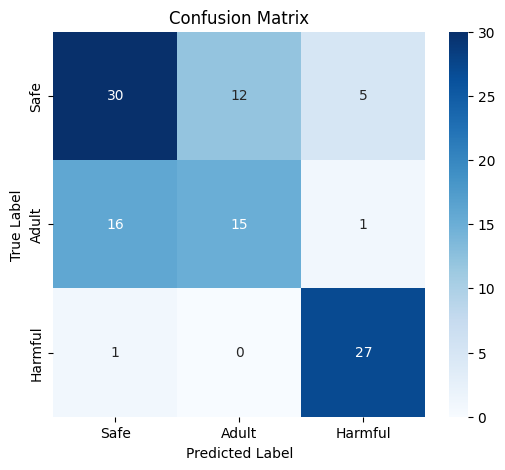

In [40]:
class_names = ['Safe', 'Adult', 'Harmful']  
plot_confusion_matrix(all_labels, all_preds, class_names)